In [24]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from venn_abers import VennAbersCalibrator
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')

In [25]:
# Function to sample balanced training and test sets
def sample_balanced_datasets_and_encode(df, target_column, train_size, test_size, random_state=None):
    # Ensure train_size and test_size are even
    if train_size % 2 != 0 or test_size % 2 != 0:
        raise ValueError("train_size and test_size must be even numbers to balance classes.")
    
    # Check that both classes have enough samples
    class_counts = df[target_column].value_counts()
    if any(class_counts < (train_size + test_size) // 2):
        raise ValueError("Not enough samples in one of the classes to create the requested balanced sets.")
    
    # Split the DataFrame by class
    class_0 = df[df[target_column] == 0]
    class_1 = df[df[target_column] == 1]
    
    # Sample train_size / 2 and test_size / 2 from each class
    train_sample_0 = class_0.sample(n=train_size // 2, random_state=random_state)
    train_sample_1 = class_1.sample(n=train_size // 2, random_state=random_state)
    test_sample_0 = class_0.drop(train_sample_0.index).sample(n=test_size // 2, random_state=random_state)
    test_sample_1 = class_1.drop(train_sample_1.index).sample(n=test_size // 2, random_state=random_state)
    
    # Combine and shuffle the samples
    balanced_train = pd.concat([train_sample_0, train_sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    balanced_test = pd.concat([test_sample_0, test_sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Split into features and target
    X_train = balanced_train.drop(columns=[target_column])
    Y_train = balanced_train[target_column]
    X_test = balanced_test.drop(columns=[target_column])
    Y_test = balanced_test[target_column]

    # Encode the features
    X_train = np.array([LabelEncoder().fit(col).transform(col) for col in X_train.values.T]).T
    X_test = np.array([LabelEncoder().fit(col).transform(col) for col in X_test.values.T]).T
    Y_train = Y_train.values.reshape(1, -1)[0]
    Y_test = Y_test.values.reshape(1, -1)[0]

    return X_train, Y_train, X_test, Y_test

def U(y, d):
    if y == 0:
        if d == 'eat':
            util = 1
        if d == 'not eat':
            util = 0
    if y == 1:
        if d == 'eat':
            util = -10
        if d == 'not eat':
            util = 1
    return util

def make_decision_based_on_prediction(yhat):
    d_arr = np.empty_like(yhat)
    for i, y in enumerate(yhat):
        d_arr[i] = 'eat' if y == 0 else 'not eat'
    return d_arr

In [26]:
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X_raw = mushroom.data.features 
y_raw = mushroom.data.targets 

X = np.array([LabelEncoder().fit(col).transform(col) for col in X_raw.values.T]).T
Y = y_raw.values.reshape(1, -1)[0]
Y = (Y=='p').astype('int')

df = deepcopy(X_raw)
df['poisonous'] = Y

In [27]:
r = 2024
test_size = 100
training_set_size = 100

X_train, y_train, X_test, y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)

# Ivan's package

In [28]:
def ivap(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(n_neighbors=5)

    # Define Venn-ABERS calibrator
    va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.5, random_state=r)

    # Fit on the training set
    va.fit(X_train, y_train)

    # Generate probabilities and class predictions on the test set
    p_prime, P0_P1 = va.predict_proba(X_test, p0_p1_output=True)
    P0_P1 = P0_P1[0]
    P_prime = p_prime[:,1]
    return P_prime, P0_P1

# My dumb implementation of full VA without update

In [29]:
def one_off_va(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(n_neighbors=5)

    IR = IsotonicRegression(y_min=0, y_max=1)

    P_multi = np.zeros(shape=(X_test.shape[0], 2))

    for i, x in enumerate(X_test):
        X_fit = np.vstack((X_train, x))
        for y_hyp in [0, 1]:
            X_fit = np.vstack((X_train, x))
            y_fit = np.append(y_train, y_hyp)
            clf.fit(X_fit, y_fit)

            S_y = clf.predict_proba(X_fit)[:,1]
            IR.fit(S_y, y_fit)
            p_hyp = IR.predict(np.atleast_1d(S_y[-1]))
            P_multi[i, y_hyp] = p_hyp

    P_agg = P_multi[:,1] / (1 - P_multi[:,0] + P_multi[:,1])
    return P_agg, P_multi

# My dumb implementation of VA with expanding training set

In [30]:
def online_va(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(n_neighbors=5)

    IR = IsotonicRegression(y_min=0, y_max=1)

    P_online_multi = np.zeros(shape=(X_test.shape[0], 2))

    X_train_online = deepcopy(X_train)
    y_train_online = deepcopy(y_train)

    for i, (x, y) in enumerate(zip(X_test, y_test)):
        X_fit = np.vstack((X_train_online, x))
        for y_hyp in [0, 1]:       
            y_fit = np.append(y_train_online, y_hyp)
            clf.fit(X_fit, y_fit)

            S_y = clf.predict_proba(X_fit)[:,1]
            IR.fit(S_y, y_fit)
            p_hyp = IR.predict(np.atleast_1d(S_y[-1]))
            P_online_multi[i, y_hyp] = p_hyp
        X_train_online = X_fit
        y_train_online = np.append(y_train_online, y)

    P_online_agg = P_online_multi[:,1] / (1 - P_online_multi[:,0] + P_online_multi[:,1])
    return P_online_agg, P_online_multi

# Clf proba

In [31]:
def offline_clf_proba(X_train, y_train, X_test, y_test):
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)
    P = clf.predict_proba(X_test)[:,1]
    return P

def online_clf_proba(X_train, y_train, X_test, y_test):
    # FIXME: This looks wierd when the results are viewed
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)
    X_train_online = deepcopy(X_train)
    y_train_online = deepcopy(y_train)
    P = []
    for i, (x, y) in enumerate(zip(X_test, y_test)):
        p = clf.predict_proba(x.reshape(1,-1))[0][1]
        P.append(p)
        X_train_online = np.vstack((X_train_online, x))
        y_train_online = np.append(y_train_online, y)
        clf.fit(X_train_online, y_train_online)
    P = np.array(P)
    return P


ivap: 
	0.5667910178025072
oneoff va: 
	0.43297365682685807
log_loss va: 
	0.34237430009777836
offline proba: 
	0.6771580168160319
online proba: 
	0.6465745899772162


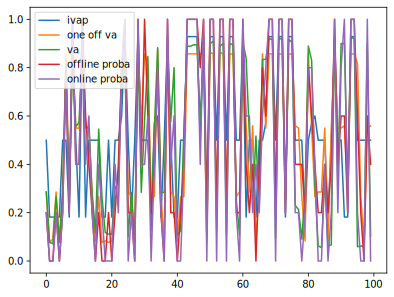

In [32]:
P_prime, P0_P1 = ivap(X_train, y_train, X_test, y_test)
P_agg, P_multi = one_off_va(X_train, y_train, X_test, y_test)
P_online_agg, P_online_multi = online_va(X_train, y_train, X_test, y_test)
Proba_offline = offline_clf_proba(X_train, y_train, X_test, y_test)
Proba_online = online_clf_proba(X_train, y_train, X_test, y_test)

plt.plot(P_prime, label='ivap')
plt.plot(P_agg, label='one off va')
plt.plot(P_online_agg, label='va')
plt.plot(Proba_offline, label='offline proba')
plt.plot(Proba_online, label='online proba')
plt.legend()

from sklearn.metrics import log_loss
print(f'ivap: \n\t{log_loss(y_test, P_prime)}')
print(f'oneoff va: \n\t{log_loss(y_test, P_agg)}')
print(f'log_loss va: \n\t{log_loss(y_test, P_online_agg)}')
print(f'offline proba: \n\t{log_loss(y_test, Proba_offline)}')
print(f'online proba: \n\t{log_loss(y_test, Proba_online)}')

Text(0.5, 1.0, 'va')

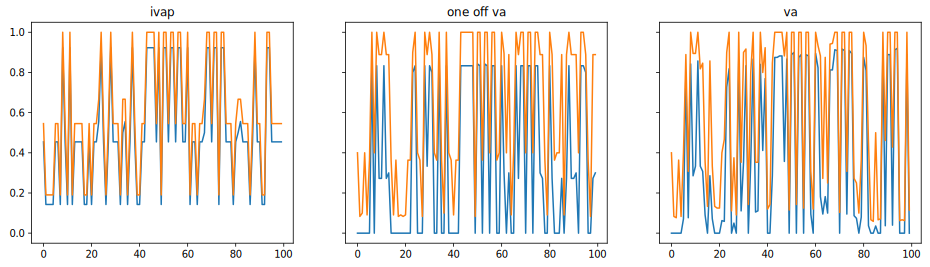

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
axs[0].plot(P0_P1)
axs[0].set_title('ivap')

axs[1].plot(P_multi)
axs[1].set_title('one off va')

axs[2].plot(P_online_multi)
axs[2].set_title('va')

# Now let's try to evaluate with utiltiy function
The minimax approach should be the safest, but let's also try the aggregated probabilities

In [34]:
def minimax_strategy(y_test, P0_P1):    
    Utility = 0
    poisonous = 0
    for probs, y_true in zip(P0_P1, y_test):

        utility_mat = np.zeros((2,2))
        probs0 = [1-probs[0], probs[0]]
        probs1 = [1-probs[1], probs[1]]

        for i, d in enumerate(['eat', 'not eat']):
            u = 0
            for p, y in zip(probs0, [0,1]):
                u += p*U(y, d)
            utility_mat[0, i] = u

            u = 0
            for p, y in zip(probs1, [0,1]):
                u += p*U(y, d)
            utility_mat[1, i] = u

        regret = utility_mat.max() - utility_mat
        d = 'not eat' if np.argwhere(regret == regret.max(axis=0).min())[0,1] == 1 else 'eat'
        Utility += U(y_true, d)
        if d == 'eat' and y_true == 1:
            poisonous += 1
    return Utility, poisonous

def aggregated_strategy(y_test, P):
    Utility = 0
    poisonous = 0
    for p, y_true in zip(P, y_test):
        probs = [1-p, p]
        utility = {}
        for d in ['eat', 'not eat']:
            u = 0
            for p, y in zip(probs, [0,1]):
                u += p*U(y, d)
            utility[d] = u
        # Choose decision with highest expected utility
        d = max(utility, key=utility.get)
        Utility += U(y_true, d)
        if d == 'eat' and y_true == 1:
            poisonous += 1
    return Utility, poisonous

In [35]:
# # Minimax
# print(f'ivap: \n\t{minimax_strategy(y_test, P0_P1)/y_test.shape[0]}')
# print(f'oneoff va: \n\t{minimax_strategy(y_test, P_multi)/y_test.shape[0]}')
# print(f'va: \n\t{minimax_strategy(y_test, P_online_multi)/y_test.shape[0]}')

In [36]:
# # Aggregated
# print(f'ivap: \n\t{aggregated_strategy(y_test, P_prime)/y_test.shape[0]}')
# print(f'oneoff va: \n\t{aggregated_strategy(y_test, P_agg)/y_test.shape[0]}')
# print(f'log_loss va: \n\t{aggregated_strategy(y_test, P_online_agg)/y_test.shape[0]}')
# print(f'offline proba: \n\t{aggregated_strategy(y_test, Proba_offline)/y_test.shape[0]}')
# print(f'online proba: \n\t{aggregated_strategy(y_test, Proba_online)/y_test.shape[0]}')

From the above, the interesting ones are Minimax ivap, Aggregated ivap, and Offline proba

In [37]:
from tqdm.notebook import tqdm

test_size = 100
runs = 1000

train_sizes = list(range(20, 501, 10))
Utility_matrix = np.zeros(shape=(len(train_sizes), 5))
Poison_matrix = np.zeros(shape=(len(train_sizes), 5))

Log_loss_matrix = np.zeros(shape=(len(train_sizes), 3))

clf = KNeighborsClassifier(n_neighbors=5)

for i, training_set_size in tqdm(enumerate(train_sizes), total=len(train_sizes), desc='Running utility strategies'):
    row = np.zeros(5)
    row_poison = np.zeros(5)

    U_ivap_minimax = 0
    U_ivap_agg = 0
    U_va_minimax = 0
    U_va_agg = 0
    U_proba = 0

    P_ivap_minimax = 0
    P_ivap_agg = 0
    P_va_minimax = 0
    P_va_agg = 0
    P_proba = 0

    logloss_ivap = 0
    logloss_va = 0
    logloss_proba = 0

    for r in range(runs):
        
        # Define Venn-ABERS calibrator
        va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.5, random_state=r)

        X_train, y_train, X_test, y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)

        P_prime, P0_P1 = ivap(X_train, y_train, X_test, y_test)
        P_agg, P_multi = one_off_va(X_train, y_train, X_test, y_test)
        Proba_offline = offline_clf_proba(X_train, y_train, X_test, y_test)

        u_ivap_minimax, p_ivap_minimax = minimax_strategy(y_test, P0_P1)
        U_ivap_minimax += u_ivap_minimax
        P_ivap_minimax += p_ivap_minimax

        u_ivap_agg, p_ivap_agg = aggregated_strategy(y_test, P_prime)
        U_ivap_agg += u_ivap_minimax
        P_ivap_agg += p_ivap_minimax

        u_va_minimax, p_va_minimax = minimax_strategy(y_test, P_multi)
        U_va_minimax += u_va_minimax
        P_va_minimax += p_va_minimax

        u_va_agg, p_va_agg = aggregated_strategy(y_test, P_agg)
        U_va_agg += u_va_agg
        P_va_agg += p_va_agg

        u_proba, p_proba = aggregated_strategy(y_test, Proba_offline)
        U_proba += u_proba
        P_proba += p_proba

        logloss_ivap += log_loss(y_test, P_prime)
        logloss_va += log_loss(y_test, P_agg)
        logloss_proba += log_loss(y_test, Proba_offline)

    row[0] = U_ivap_minimax/runs
    row[1] = U_ivap_agg/runs
    row[2] = U_va_minimax/runs
    row[3] = U_va_agg/runs
    row[4] = U_proba/runs

    Utility_matrix[i,:] = row

    Log_loss_matrix[i, 0] = logloss_ivap/runs
    Log_loss_matrix[i, 1] = logloss_va/runs
    Log_loss_matrix[i, 2] = logloss_proba/runs

    row_poison[0] = P_ivap_minimax/runs
    row_poison[1] = P_ivap_agg/runs
    row_poison[2] = P_va_minimax/runs
    row_poison[3] = P_va_agg/runs
    row_poison[4] = P_proba/runs

    Poison_matrix[i,:] = row_poison

Running utility strategies:   0%|          | 0/49 [00:00<?, ?it/s]

In [38]:
np.sum([U(y, d) for y, d in zip(y_test, ['eat' if y ==0 else 'not eat' for y in y_test])])/test_size

1.0

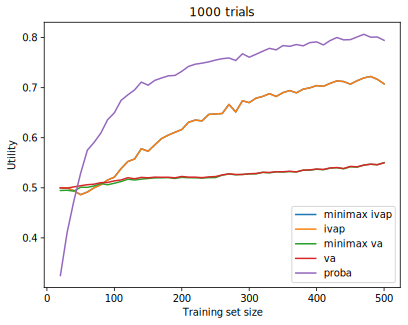

In [39]:
plt.plot(train_sizes, Utility_matrix/test_size)
plt.title('1000 trials')
plt.legend(['minimax ivap', 'ivap', 'minimax va', 'va', 'proba'])
plt.xlabel('Training set size')
plt.ylabel('Utility')
plt.savefig('Utility.pdf')

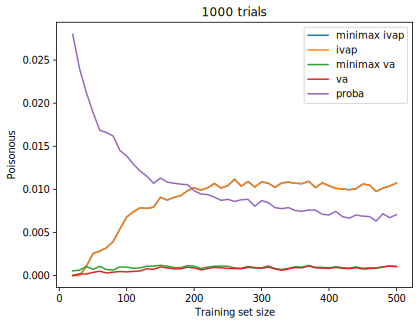

In [40]:
plt.plot(train_sizes, Poison_matrix/test_size)
plt.title('1000 trials')
plt.legend(['minimax ivap', 'ivap', 'minimax va', 'va', 'proba'])
plt.xlabel('Training set size')
plt.ylabel('Poisonous')
plt.savefig('Poisonous.pdf')

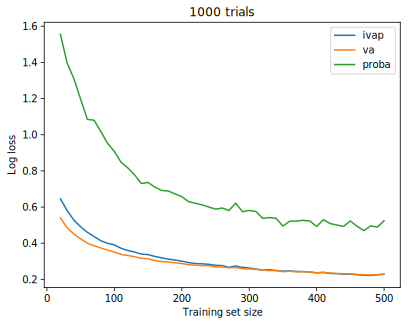

In [41]:
plt.plot(train_sizes, Log_loss_matrix)
plt.title('1000 trials')
plt.legend(['ivap', 'va', 'proba'])
plt.xlabel('Training set size')
plt.ylabel('Log loss')
plt.savefig('LogLoss.pdf')